# Sentiment analysis

Sentiment analysis is a natural language processing (NLP) technique to determine the sentiment of a sentence. In this implementation, we propose to use quantum natural language processing (QNLP) as an alternative to solve this problem. QNLP enables the resolution of NLP tasks taking advantage of the inherent quantum nature of language, allowing to take into account the grammar of sentences and to work in an exponentially large Hilbert space, easing the memory problems of its classical counterpart.

In this Jupyter Notebook we show how to solve a sentiment analysis problem. More concretely, it is a multi-class classification task where the sentences of a dataset are divided into four categories: happy, sad, angry and scared. As a reference for the resolution of this problem we use the paper by Lorenz et al https://arxiv.org/abs/2102.12846, where they solve a binary classification problem. Their code and resources can be found in https://github.com/CQCL/qnlp_lorenz_etal_2021_resources.

## 1. Create dataset

The first step is to create the dataset for our task. It is important to create a balanced dataset suitable for this problem. In order to do that, we have chosen the following words
 
| Nouns | Verbs | Adjectives |
| --- | --- | --- |
| Man | cries | morose |
| Woman | laughs | irascible |
| Kid | shouts | frightened |
|  | snaps | cheerful |
|  | entertains | gloomy |
|  | grieves | furious |
|  | startles | terrified |
|  | irritates |joyful|
|  |  | downcast|
|  |  | miserable|
|  |  | old|
|  |  | young|

We can observe that we have three different types of words: nouns, verbs and adjectives. The information regarding the meaning of the sentence is going to be given by the verb, the adjective or the combination of both, as there are verbs that can be used to express more than one feeling, or adjectives that show no sentiment ('young', 'old')

The proposed vocabulary has 23 words, with which we write 366 sentences, for example


- Morose man cries. (morose)
- Irascible woman shouts. (irascible)
- Frightened woman shouts. (frightened)
- Joyful kid laughs. (joyful, laughs)
- Furious man snaps. (furious)
- Kid startles man. (startles)
- Woman grieves man. (grieves)
...

The brackets indicate the word or words that enclose the sentiment in each example.

We are going to consider four classes of sentences:
- Adj + Subject + Intransitive verb
- Subject + Transitive verb + Object
- Adjective + Subject + Transitive verb + Object
- Subject + Transitive verb + Adjective + Object

The steps to construct the dataset are the following ones. We first store the words in DisCoPy's Word objects, encoding their meaning (name) and their grammar (codomain). Then, we introduce the grammar of the allowed sentences and create all the possible grammatical sentences. The next step is to assign a sentiment to each sentence. However, there are sentences that although they are grammatically correct, their meaning makes no sense, so we would have to remove them. 

### 1.1. Define the vocabulary

The first step to create a dataset is to define the words, their meaning and the word type. We have four three types of words: nouns, adjectives, verbs. We also distinguish two different types of verbs: transitive and intransitive. 

In [1]:
import numpy as np
import pickle

In [2]:
from discopy import Ty, Word # Import the classes for the type of word and for the word

s, n = Ty('s'), Ty('n') # Define the types s and n

# Define the words
# Nouns
man, woman, kid = Word('man', n), Word('woman', n), Word('kid', n)

# Adjectives
morose, irascible = Word('morose', n @ n.l), Word('irascible', n @ n.l)
frightened, cheerful = Word('frightened', n @ n.l), Word('cheerful', n @ n.l)
gloomy, furious = Word('gloomy', n @ n.l), Word('furious', n @ n.l)
terrified, joyful = Word('terrified', n @ n.l), Word('joyful', n @ n.l)
downcast, miserable = Word('downcast', n @ n.l), Word('miserable', n @ n.l)

old, young = Word('old', n @ n.l), Word('young', n @ n.l)
# Intransitive verbs
cries, shouts = Word('cries', n.r @ s), Word('shouts', n.r @ s)
laughs, snaps = Word('laughs', n.r @ s), Word('snaps', n.r @ s)

# Transitive verbs
grieves, startles = Word('grieves', n.r @ s @ n.l), Word('startles', n.r @ s @ n.l)
entertains, irritates = Word('entertains', n.r @ s @ n.l), Word('irritates', n.r @ s @ n.l)

nouns = [man, woman, kid]
adjectives = [morose, irascible, frightened, cheerful, gloomy, furious, terrified, joyful, downcast, miserable, old, young]
int_verbs = [cries, shouts, laughs, snaps]
t_verbs = [grieves, startles, entertains, irritates]

vocab = nouns + int_verbs + t_verbs + adjectives

### 1.2. Define the grammar

Each type of sentence has an associated grammar depending on the relations among the words that compound them.

- Intransitive sentence

Adj + Subject + Intransitive verb

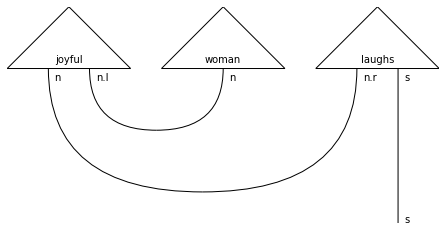

In [3]:
from discopy import Cup, Id, pregroup

grammar =  Id(n) @ Cup(n.l, n) @ Id(n.r @ s) >> Cup(n, n.r) @ Id(s) >> Id(s)
sentence = joyful @ woman @ laughs >> grammar
pregroup.draw(sentence)

- Transitive sentence

- Subject + Transitive verb + Object

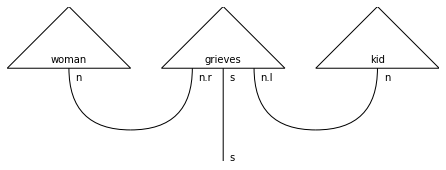

In [4]:
grammar =  Cup(n, n.r) @ Id(s) @ Cup(n.l, n)
sentence = woman @ grieves @ kid >> grammar
pregroup.draw(sentence)

Adjective + Subject + Transitive verb + Object

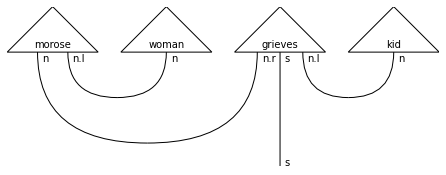

In [5]:
grammar =  Id(n) @ Cup(n.l, n) @ Id(n.r @ s) @ Cup(n.l, n) >> Cup(n, n.r) @ Id(s) >> Id(s)
sentence = morose @ woman @ grieves @ kid >> grammar
pregroup.draw(sentence)

Subject + Transitive verb + Adjective + Object

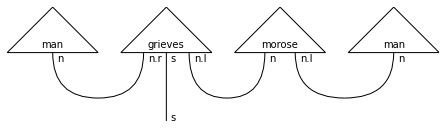

In [6]:
grammar =  Cup(n, n.r) @ Id(s) @ Cup(n.l, n) @ Cup(n.l, n) >> Id(s)
sentence =  man @ grieves @ morose @ man >> grammar
pregroup.draw(sentence)

Now we have seen how the grammatical structure of each type of sentence is, so we are ready to obtain all the grammatical sentences that we can construct with them with the vocabulary that we are using. 

In [7]:
# Store the grammatical structures in a dictionary 

grammar_dict = {
    'ADJ_N_IV' : Id(n) @ Cup(n.l, n) @ Id(n.r @ s) >> Cup(n, n.r) @ Id(s) >> Id(s),
    'N_TV_N': Cup(n, n.r) @ Id(s) @ Cup(n.l, n),
    'ADJ_N_TV_N': Id(n) @ Cup(n.l, n) @ Id(n.r @ s) @ Cup(n.l, n) >> Cup(n, n.r) @ Id(s) >> Id(s),
    'N_TV_ADJ_N': Cup(n, n.r) @ Id(s) @ Cup(n.l, n) @ Cup(n.l, n) >> Id(s)}
                                                                          

# Create parsing (grammatical analysis) dictionary where the grammatical sentences
# are the keys and the associated values are the diagrams (words + grammar)

data_psr = {}

# Intransitive sentences
parsing_int = {"{} {} {}.".format(adj, noun, int_verb): adj @ noun @ int_verb >> grammar_dict['ADJ_N_IV']
            for adj in adjectives for noun in nouns for int_verb in int_verbs}
sentences_int = list(parsing_int.keys())
for sentence in sentences_int:
    diagram = parsing_int[sentence]
    data_psr[sentence] = parsing_int[sentence]

# Transitive sentences (without adjective)
parsing_tra = {"{} {} {}.".format(subj, t_verb, obj):  subj @ t_verb @ obj >> grammar_dict['N_TV_N']
            for subj in nouns for t_verb in t_verbs for obj in nouns}


# Transitive sentences (with adjective)
parsing_tra_ladj = {"{} {} {} {}.".format(adj, subj, t_verb, obj):  adj @ subj @ t_verb @ obj >> grammar_dict['ADJ_N_TV_N']
            for adj in adjectives for subj in nouns for t_verb in t_verbs for obj in nouns}
parsing_tra_radj = {"{} {} {} {}.".format(subj, t_verb, adj, obj):  subj @ t_verb @ adj @ obj >> grammar_dict['N_TV_ADJ_N']
            for subj in nouns for t_verb in t_verbs for adj in adjectives for obj in nouns}

parsing_tra.update(parsing_tra_ladj) #merges transitive adjectives into original dict
parsing_tra.update(parsing_tra_radj)

sentences_tra = list(parsing_tra.keys())
for sentence in sentences_tra:
    diagram = parsing_tra[sentence]
    data_psr[sentence] = parsing_tra[sentence]

Now, we have the dataset with the sentences and their corresponding meaning and grammar. We are aiming to distinguish between four different emotions: happy (0), sad (1), angry (2), scared (3). However, some sentences of the dataset cannot be clearly classified according to this criteria (for example, 'Old man shouts'). Therefore, the next step is to manually modify the dataset so all the sentences can be classified according to this criteria. In order to do that we will create a .txt file and assign the corresponding class to the viable sentences. The result is the sentiment_analysis_dataset.txt. 

### 1.3. Process the data

The next step is to upload the dataset and process the data so it is written in the more efficient way.

In [8]:
with open('sentiment_analysis_dataset.txt') as f:
    data = f.readlines()

In [9]:
labels_dict = {} # Dictionary with the labels for each sentence
data_psr_dict = {} # Dictionary with the parsing for each sentence
sent_type = {} # Dictionary with the sentence type for each sentence

adjective_words = [a.name for a in adjectives]
for sentence in data:
    sentstr = sentence[:-7]
    if sentence[-6:-3] == 'int':
        diagram = parsing_int[sentstr]
        data_psr_dict[sentstr] = diagram
        labels_dict[sentstr] = sentence[-2]
        sent_type[sentstr] = 'int'
    elif sentence[-6:-3] == 'tra':
        diagram = parsing_tra[sentstr]
        data_psr_dict[sentstr] = diagram
        labels_dict[sentstr] = sentence[-2]

        if len(sentstr.split()) == 4:
            if sentstr.split()[0] in adjective_words:
                sent_type[sentstr] = 'tra_' + 'l'
            else:
                sent_type[sentstr] = 'tra_' + 'r'
        else:
            sent_type[sentstr] = 'tra'  

In [10]:
c0 = 0
c1 = 0
c2 = 0
c3 = 0
for value in labels_dict.values():
    if value == '0':
        c0 +=1
    elif value == '1':
        c1 += 1
    elif value == '2':
        c2 += 1
    elif value == '3':
        c3 += 1
print('Number of elements for each sentiment')
print('Happy: ', c0)
print('Sad: ', c1)
print('Angry: ', c2)
print('Scared: ', c3)
print('Total: ', len(data_psr_dict))

Number of elements for each sentiment
Happy:  90
Sad:  96
Angry:  93
Scared:  87
Total:  366


Now we have our dataset! The only problem left is the fact that the cups used in the diagrams are too resource consumming. Luckily, it is possible to remove them by transforming the states into effects (we are just doing this with the nouns as in https://github.com/CQCL/qnlp_lorenz_etal_2021_resources). Let us see some examples

In [11]:
from discopy import Cap, Box

Let us apply this to our entire dataset.

In [12]:
# Code of this cell addapted from https://github.com/CQCL/qnlp_lorenz_etal_2021_resources

data_new_psr_dict = {}
for sentstr in data_psr_dict.keys():
    num_words = len(sentstr.split(' '))
    words = data_psr_dict[sentstr].boxes[:num_words]
    if sent_type[sentstr] == 'int':
        noun = Box(words[1].name, n.l, Ty()) 
        words_new = (Cap(n, n.l)) >> (words[0] @ Id(n) @ noun @ words[2]) # Rearranged words
        sentence = words_new >> grammar_dict['ADJ_N_IV'] # Apply grammar on rearranged words
        data_new_psr_dict[sentstr] = sentence.normal_form() # Store sentece with optimum diagram
    elif 'tra' in sent_type[sentstr]:
        if sent_type[sentstr] == 'tra':
            noun1 = Box(words[0].name, n.r, Ty())
            noun2 = Box(words[2].name, n.l, Ty())
            words_new = (Cap(n.r, n) @ Cap(n, n.l)) >> (noun1 @ Id(n) @ words[1] @ Id(n) @ noun2)
            sentence = words_new >> grammar_dict['N_TV_N']
            data_new_psr_dict[sentstr] = sentence.normal_form()
        elif sent_type[sentstr] == 'tra_l': #adjective at beginning
            noun1 = Box(words[1].name, n.l, Ty())
            noun2 = Box(words[3].name, n.l, Ty())
            words_new = (Cap(n, n.l) @ Cap(n, n.l)) >> (words[0] @ Id(n) @ noun1 @ words[2] @ Id(n) @ noun2)
            sentence = words_new >> grammar_dict['ADJ_N_TV_N']
            data_new_psr_dict[sentstr] = sentence.normal_form()
        elif sent_type[sentstr] == 'tra_r': #adjective on second noun
            noun1 = Box(words[0].name, n.r, Ty())
            noun2 = Box(words[3].name, n.l, Ty())
            words_new = (Cap(n.r, n) @ Cap(n, n.l)) >> (noun1 @ Id(n) @ words[1] @ words[2] @ Id(n) @ noun2)
            sentence = words_new >> grammar_dict['N_TV_ADJ_N']
            data_new_psr_dict[sentstr] = sentence.normal_form() 

The final step before the implementation of the quantum circuit is to redefine the vocabulary according to the new domain and codamain for the nouns as effects.

In [13]:
# Code of this cell from https://github.com/CQCL/qnlp_lorenz_etal_2021_resources

vocab_psr = []
for word in vocab:
    if word.cod == Ty('n'):
        vocab_psr.append(Box(word.name, n.r, Ty()))   # n.l case is dealt with in definition of quantum functor
    else:
        vocab_psr.append(word)

## 2. Create quantum circuits

Once the dataset and its corresponding diagrams are created, the next step is to construct the variational quantum circuits associated with the words in it. In order to do that, we will use different ansätze depending on the type of the word that we want to represent. In this case we have three types of words: nouns, adjectives and verbs. Before deciding which kind of circuit is associated to each of them, it is necessary to discuss the multi-class classification approach that we will use. In this notebook, we apply what is known as one versus one (OvO or 1vs1) multi-class classification. This multi-class classification scheme consists on training $N(N-1)/2$ binary classifiers, where $N$ is the number of classes. Each binary classifier is trained for a subset of the training dataset where just two classes are considered. After all the classifiers are trained, the test set is evaluated for each of them, and the label that is obtained a greater number of times is assigned as the predicted label. When there is no winning label, it is randomly assigned among the most obtained ones.

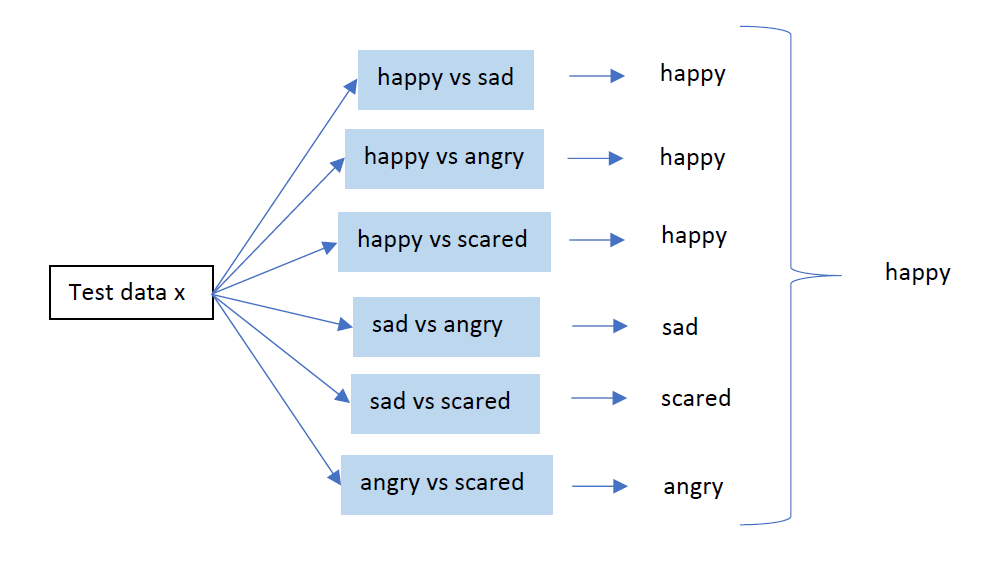

The supervised learning is carried out using a hybrid quantum-classical algorithm in which a classical optimizer (SPSA) updates the parameters of the variational quantum circuits encoding the sentences according to a cost function that uses the values of the evaluations of the circuits. This is basically a variational quantum eigensolver, but instead of optimizing just one circuit, we optimize as many circuits as sentences in the dataset.

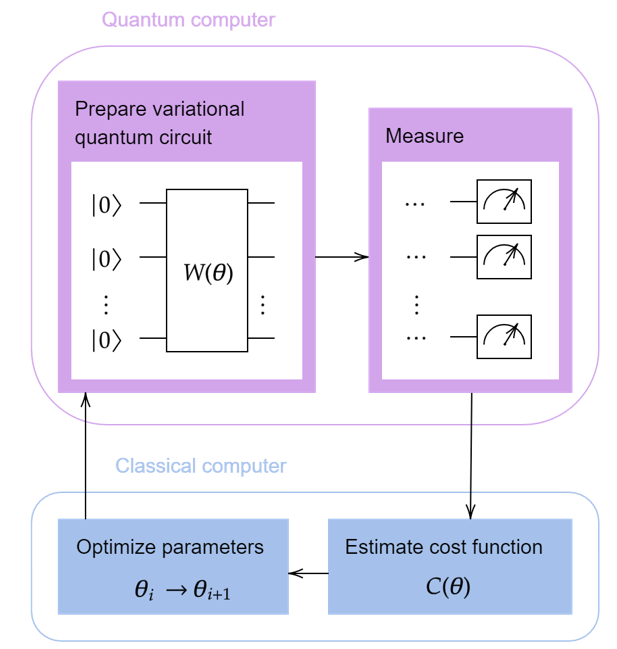

As we will be using binary classifiers, we can encode both $n$ and $s$ types in 1 qubit, as we only have two labels and we just need a 1-qubit state for the postselection to obtain the prediction from the quantum circuit. Therefore, we resort to the code for the mc_task in https://github.com/CQCL/qnlp_lorenz_etal_2021_resources to define the ansätze associated to each word type. More concretely, we will use the IQP ansatz with 3 parameters for the single qubit case.

In [14]:
# Code of this cell from https://github.com/CQCL/qnlp_lorenz_etal_2021_resources

#*****************************************************
# Translation to quantum circuits
#*****************************************************

from discopy.quantum import Ket, IQPansatz, Bra, qubit
from discopy.quantum.circuit import Functor, Id
from discopy.quantum.circuit import Circuit
from functools import reduce, partial
from discopy.quantum.gates import Rx, Rz

q_s = 1 # number of qubits for type s (sentence)
q_n = 1 # number of qubits for type n (noun)
depth = 1 # depth of the IQPansatz
p_n = 3 # number of parameters for the single qubit iqp ansatz

# Define the dimensions of the objects of the circuit functor
ob = {s: q_s, n: q_n}                          
ob_cqmap = {s: qubit ** q_s, n: qubit ** q_n}   

#-----------------------------------------
# parametrised part of ansaetze
#-----------------------------------------

def single_qubit_iqp_ansatz(params):
    if len(params) == 1:
        return Rx(params[0])  
    if len(params) == 2:
        return Rx(params[0]) >> Rz(params[1])
    if len(params) == 3:
        return IQPansatz(1, params)     
    
def ansatz_state(state, params):
    arity = sum(ob[Ty(factor.name)] for factor in state.cod) 
    if arity == 1:
        return Ket(0) >> single_qubit_iqp_ansatz(params)
    return Ket(*tuple([0 for i in range(arity)])) >> IQPansatz(arity, params)
    
def ansatz_effect(effect, params): 
    arity = sum(ob[Ty(factor.name)] for factor in effect.dom)
    if arity == 1:
        return single_qubit_iqp_ansatz(params) >> Bra(0)
    return IQPansatz(arity, params) >> Bra(*tuple([0 for i in range(arity)]))
       
def ansatz(box,params):
    dom_type = box.dom
    cod_type = box.cod
    if len(dom_type) == 0 and len(cod_type) != 0:
        return ansatz_state(box, params)
    if len(dom_type) != 0 and len(cod_type) == 0:
        return ansatz_effect(box, params)

#----------------------------------------------------------
# Define parametrised functor to quantum circuits
#----------------------------------------------------------def F(params): 
def F(params): 
    ar = dict()
    for i in range(len(vocab_psr)):
        pgbox = vocab_psr[i]
        qbox = ansatz(vocab_psr[i], params[i])
        ar.update({pgbox: qbox})
        if pgbox.cod == Ty():
            ar.update({Box(pgbox.name, n.l, Ty()): qbox})  # send the effect with n.l to same quantum effect
    return Functor(ob_cqmap, ar)

In [15]:
# Code of this cell from https://github.com/CQCL/qnlp_lorenz_etal_2021_resources

#*****************************************************
# Functions to deal with the parametrisation
#*****************************************************
def paramshapes(vocab_psr):
    parshapes = []    
    for box in vocab_psr:
        dom_type = box.dom
        cod_type = box.cod
        dom_arity = sum(ob[Ty(factor.name)] for factor in box.dom)
        cod_arity = sum(ob[Ty(factor.name)] for factor in box.cod)
        if dom_arity == 0 or cod_arity == 0:  # states and effects
            arity = max(dom_arity, cod_arity)
            assert arity != 0
            if arity == 1:
                parshapes.append((p_n,))       
            if arity != 1:
                parshapes.append((depth, arity-1))
    return parshapes

def randparams(par_shapes):
    params = np.array([]) 
    for i in range(len(par_shapes)):
        params = np.concatenate((params, np.ravel(np.random.rand(*par_shapes[i])))) # np.ravel flattens an array
    return params 

def reshape_params(unshaped_pars, par_shapes):
    pars_reshaped = [[] for ii in range(len(par_shapes))]
    shift = 0
    for ss, s in enumerate(par_shapes):
        idx0 = 0 + shift
        if len(s) == 1:
            idx1 = s[0] + shift
        elif len(s) == 2:
            idx1 = s[0] * s[1] + shift
        pars_reshaped[ss] = np.reshape(unshaped_pars[idx0:idx1], s)
        if len(s) == 1:
            shift += s[0]
        elif len(s) == 2:
            shift += s[0] * s[1]
    return pars_reshaped

In [16]:
# Code of this cell from https://github.com/CQCL/qnlp_lorenz_etal_2021_resources

#****************************************
# Parameters of the current model
#****************************************

par_shapes = paramshapes(vocab_psr)
rand_unshaped_pars = randparams(par_shapes)
rand_shaped_pars = reshape_params(rand_unshaped_pars, par_shapes)

print('Number of parameters:    ', len(rand_unshaped_pars))

Number of parameters:     33


## 3. Create training and test dataset

The next step is to divide our dataset into training and test data, so we can perform the classification using a supervised quantum machine learning technique. We need the data, which are the quantum circuits associated to each sentences, and the labels, that encode the sentiment. In this case the labels are 

- Happy: $ \ 0 \ \rightarrow \ |00\rangle = [1,0,0,0] \ \rightarrow \ p_{00}=1$,
- Sad: $ \ 1 \ \rightarrow \ |01\rangle = [0,1,0,0] \ \rightarrow \ p_{01}=1$,
- Angry: $ \ 2 \ \rightarrow \ |10\rangle = [0,0,1,0] \ \rightarrow \ p_{10}=1$,
- Scared: $ \ 3 \ \rightarrow \ |11\rangle = [0,0,0,1] \ \rightarrow \ p_{11}=1$.

In [17]:
from sklearn.model_selection import train_test_split

psr_diagrams = []
psr_diagrams_dict = {}
psr_labels = []
sentences = []

for sentstr in data_new_psr_dict.keys():
    sentences.append(sentstr)
    diagram = data_new_psr_dict[sentstr]
    psr_diagrams.append(diagram)
    psr_diagrams_dict[sentstr] = diagram
    if labels_dict[sentstr] == '0':
        label = np.array([1,0])
    elif labels_dict[sentstr] == '1':
        label = np.array([0,1])
    psr_labels.append(label)

train_data_psr, test_data_psr, train_labels, test_labels = \
    train_test_split(psr_diagrams, psr_labels, test_size=0.25, random_state=42)

Once the dataset is divided into training and testing data, we subdivide the training data into six binary datasets of the form train_sentiment1_vs_sentiment2.txt. We perform the binary classification for each of them, with labels

- Sentiment 1: $ \ 0 \ \rightarrow \ |0\rangle = [1,0] \ \rightarrow \ p_{0}=1$,
- Sentiment 2: $ \ 1 \ \rightarrow \ |1\rangle = [0,1] \ \rightarrow \ p_{1}=1$,

that correspond to the two outcomes of the measurement of 1 post-selected qubit.

## 4. Hybrid quantum-classical variational algorithm

In this section we describe how to use Qiskit to create a hybrid quantum-classical variational algorithm to obtain the results of the sentiment analysis for each classifier. 

First, we download the necessary packages. In order to apply the noisy simulator of the ibmq_16_melbourne quantum computer, remove the #, or use noise_model_melbourne.pkl (the one we used, the noise model of that device with data 2/06/2021).

In [18]:
from qiskit import BasicAer, execute, ClassicalRegister
from pytket.extensions.qiskit import tk_to_qiskit
from qiskit.quantum_info import Statevector
#from qiskit import IBMQ
#from qiskit.providers.aer.noise import NoiseModel

backend = BasicAer.get_backend('qasm_simulator')
noise_model = None
coupling_map = None
basis_gates= None

## Build noise model from backend properties
#provider = IBMQ.load_account()
#backend = provider.get_backend('ibmq_16_melbourne')
#noise_model = NoiseModel.from_backend(backend)

## Get coupling map from backend
#coupling_map = backend.configuration().coupling_map

## Get basis gates from noise model
#basis_gates = noise_model.basis_gates

#backend = Aer.get_backend('qasm_simulator')

max_shots = 8192

C:\Users\Paula\Anaconda3\envs\qnlp\lib\site-packages\qiskit\aqua\operators\operator_globals.py:48: DeprecationWarning: `from_label` is deprecated and will be removed no earlier than 3 months after the release date. Use Pauli(label) instead.
  X = make_immutable(PrimitiveOp(Pauli.from_label('X')))


In [19]:
#with open(f'./noise_model_melbourne.pkl', "rb") as fp:  
    #data = pickle.load(fp)
#noise_model, coupling_map, basis_gates = data[0], data[1], data[2]

First, we define the functions to transform a DisCoPy circuit into a Qiskit one and obtain the results after postselection that correspond to the predicted label of the sentece encoded in the quantum circuit. It allows us to use the statevector simulator, the qasm simulator or introducing a noise model, which are the three possibilities that we have considered for our simulations. In order to run the code in an IBMQ device, we just need to change the backend to the desired one and import the IBMQ account.

In [20]:
from qiskit import Aer

def get_qiskit_results(circ, s_type, retries=10, qasm=False, noise_model=None, 
                       basis_gates=None, coupling_map=None, max_shots=8192):
    """Function to get the Qiskit's results from a DisCoPy circuit.
    
    Args:
        circ = DisCoPy circuit.
        s_type = sentence type for the sentence associated to the circuit.
        retries = number of retries before assigning a random result
            if the postselection leads to zero values (Default is 10).
        qasm = if True qasm_simulator is used, if not statevector_simulator
            (Default is False).
        noise_model = Qiskit's noise model object (Default is None).
        basis_gates = basis gates of the device (Default is None).
        coupling_map = coupling_map of the device (Default is None).
        max_shots = number of shots (Default is 8192).
        
            
    Returns:
        array: results from the postselection measurement.
    """
    
    # Select qubits for postselection according to the sentence type    
    
    if s_type == 'int':
        n_qubits = 4
        post = 2
    elif s_type == 'tra':
        n_qubits = 3
        post = 1
    elif s_type == 'tra_l':
        n_qubits = 5
        post = 2
    else:
        assert s_type == 'tra_r'
        n_qubits = 5
        post = 1
    
    # From DisCoPy to Qiskit circuit    
    qc = tk_to_qiskit(circ.to_tk())
    if qasm == True:
        #qasm_simulator
        out_reg = ClassicalRegister(1)
        qc.add_register(out_reg)
        qc.measure(post, out_reg[0]) 
        if noise_model is not None:
            backend = Aer.get_backend('qasm_simulator')

            # Include noise model
            results = execute(qc, backend, shots=max_shots, noise_model=noise_model, 
                              coupling_map=coupling_map,basis_gates=basis_gates).result().get_counts()
        else:
            backend = BasicAer.get_backend('qasm_simulator')
            results = execute(qc, backend, shots=max_shots).result().get_counts()

        zeros = '0' * (n_qubits - 1)

        if '0 ' + zeros not in results and '1 ' + zeros not in results:
            if retries == 0:
                return np.random.rand(2)
            return get_qiskit_results(circ, s_type, retries=retries-1, qasm = qasm,
                                     noise_model=noise_model, coupling_map=coupling_map,
                                     basis_gates=basis_gates, max_shots = max_shots)

        return parse_results(results, eff=zeros)
    
    else:
        # statevector_simulator
        qc.remove_final_measurements()
        state_dict = Statevector(qc).to_dict()
        post0, post1 = '0' * n_qubits, '0' * n_qubits
        post1 = post1[:post] + '1' + post1[post + 1:]
        return [np.abs(state_dict[post0])**2, np.abs(state_dict[post1])**2]
    
def parse_results(results, eff='0'):
    """Parse results of qasm_simulator.
    
    Args:
        results: counts from quantum circuit's measurement.
        eff: digits for splitting the results for post selection.
        
    Returns:
        array: post selected results.
    """
    ks = [k for k in results.keys() if k.split()[1] == eff]
    post_selected_results = {k.split()[0]:v for (k,v) in results.items() if k in ks}
    
    if '0' not in post_selected_results:
        post_selected_results['0'] = 0
    if '1' not in post_selected_results:
        post_selected_results['1'] = 0
        
    total = post_selected_results['0'] + post_selected_results['1']
    
    assert total > 0, 'total was 0 after postselection - try running with more shots'
    
    
    return [post_selected_results['0']/total,  post_selected_results['1']/total]

We define the cost functions. We have chosen the train error and the cross entropy as possible cost functions. As they use global variables, they are defined inside the optimization function. An alternative is to construct a Jupyter notebook for each classifier or one and change the dataset depending on the result we want to obtain. This way we could define the cost function outside the optimization fuction but we will still need the global variables.

As in order to perform the optimization we need the parsing diagrams, labels and sentences of each binary dataset, we define the following function using the previous code.

In [21]:
def process_dataset(dataset):
    """ Process a QNLP dataset.
    
    Args:
        dataset: txt dataset to be processed.
    
    Returns:
        psr_diagrams: parsing diagrams.
        psr_labels: labels.
        sentences: sentences.
        sent_type: dictionary with the sentence type for each sentence.
    """
    with open(dataset) as f:
        data = f.readlines()
    labels_dict = {} # Dictionary with the labels for each sentence
    data_psr_dict = {} # Dictionary with the parsing for each sentence
    sent_type = {} # Dictionary with the sentence type for each sentence
    # Create the previous dictionaries from the given dataset
    adjective_words = [a.name for a in adjectives]
    for sentence in data:
        sentstr = sentence[:-7]
        if sentence[-6:-3] == 'int':
            diagram = parsing_int[sentstr]
            data_psr_dict[sentstr] = diagram
            labels_dict[sentstr] = sentence[-2]
            sent_type[sentstr] = 'int'
        elif sentence[-6:-3] == 'tra':
            diagram = parsing_tra[sentstr]
            data_psr_dict[sentstr] = diagram
            labels_dict[sentstr] = sentence[-2]

            if len(sentstr.split()) == 4:
                if sentstr.split()[0] in adjective_words:
                    sent_type[sentstr] = 'tra_' + 'l'
                else:
                    sent_type[sentstr] = 'tra_' + 'r'
            else:
                sent_type[sentstr] = 'tra'  
    # Rearrange the parsing of the diagrams
    data_new_psr_dict = {}
    for sentstr in data_psr_dict.keys():
        num_words = len(sentstr.split(' '))
        words = data_psr_dict[sentstr].boxes[:num_words]
        if sent_type[sentstr] == 'int':
            noun = Box(words[1].name, n.l, Ty()) 
            words_new = (Cap(n, n.l)) >> (words[0] @ Id(n) @ noun @ words[2]) # Rearranged words
            sentence = words_new >> grammar_dict['ADJ_N_IV'] # Apply grammar on rearranged words
            data_new_psr_dict[sentstr] = sentence.normal_form() # Store sentece with optimum diagram
        elif 'tra' in sent_type[sentstr]:
            if sent_type[sentstr] == 'tra':
                noun1 = Box(words[0].name, n.r, Ty())
                noun2 = Box(words[2].name, n.l, Ty())
                words_new = (Cap(n.r, n) @ Cap(n, n.l)) >> (noun1 @ Id(n) @ words[1] @ Id(n) @ noun2)
                sentence = words_new >> grammar_dict['N_TV_N']
                data_new_psr_dict[sentstr] = sentence.normal_form()
            elif sent_type[sentstr] == 'tra_l': #adjective at beginning
                noun1 = Box(words[1].name, n.l, Ty())
                noun2 = Box(words[3].name, n.l, Ty())
                words_new = (Cap(n, n.l) @ Cap(n, n.l)) >> (words[0] @ Id(n) @ noun1 @ words[2] @ Id(n) @ noun2)
                sentence = words_new >> grammar_dict['ADJ_N_TV_N']
                data_new_psr_dict[sentstr] = sentence.normal_form()
            elif sent_type[sentstr] == 'tra_r': #adjective on second noun
                noun1 = Box(words[0].name, n.r, Ty())
                noun2 = Box(words[3].name, n.l, Ty())
                words_new = (Cap(n.r, n) @ Cap(n, n.l)) >> (noun1 @ Id(n) @ words[1] @ words[2] @ Id(n) @ noun2)
                sentence = words_new >> grammar_dict['N_TV_ADJ_N']
                data_new_psr_dict[sentstr] = sentence.normal_form() 
    # Store the diagrams, labels and sentences for the classification
    psr_diagrams = []
    psr_diagrams_dict = {}
    psr_labels = []
    sentences = []
    for sentstr in data_new_psr_dict.keys():
        sentences.append(sentstr)
        diagram = data_new_psr_dict[sentstr]
        psr_diagrams.append(diagram)
        psr_diagrams_dict[sentstr] = diagram
        if labels_dict[sentstr] == '0':
            label = np.array([1,0])
        elif labels_dict[sentstr] == '1':
            label = np.array([0,1])
        psr_labels.append(label)
        
    return psr_diagrams, psr_labels, sentences, sent_type

Finally, we define a function for the optimization using Qiskit's SPSA optimizer.

In [22]:
from qiskit.aqua.components.optimizers import SPSA
import time

def QNLP_optimize(dataset, initial_point, n_iterations, cost_function, qasm_bool=False,
                  noise_model=None, coupling_map=None, basis_gates=None, max_shots = 8192):
    """ Optimize a QNLP dataset.
    
    Args:
        dataset = dataset for the optimization.
        initial_point = initial value of the parameters.
        niter = number of iterations for SPSA optimizer.
        cost_function = cost function for the optimization
        qasm_bool: if True qasm_simulator is used, if not
            statevector_simulator (Default is False).
    Returns:
        list: Qiskit's SPSA results.
        cost_save: cost of each evaluation of the cost function.
        params_save: parameters of each evaluation of the cost function.
    """
    # Obtain the data from the dataset
    train_data_psr, train_labels, train_sent, sent_type = process_dataset(dataset)

    # Qiskit's SPSA parameters
    num_vars = len(initial_point)
    bounds = [[0.0, 1.0] for _ in range(len(initial_point))]
    
    # Initialize cost function global parameters
    cost_save = []
    params_save = []
    i_cost = []
    # Choose cost function
    if cost_function == 'cost_train':
        def get_cost_train_error(unshaped_params):
            """ Cost function using training error.

            Args:
                unshaped_params: parameters for the optimization.

            Returns:
                float: cost.
            """
            # Print iterations
            i_cost.append(1)
            if len(i_cost) % 2 == 0:
                print('Iteration', len(i_cost)/2)

            # Create functor to construct DisCoPy circuits
            func = F(reshape_params(unshaped_params, par_shapes))
            circs = [func(diag) for diag in train_data_psr]
            # Get Qiskit's results
            results = np.array([get_qiskit_results(circs[i], sent_type[train_sent[i]], qasm = qasm_bool,
                                     noise_model=noise_model, coupling_map=coupling_map,
                                     basis_gates=basis_gates, max_shots=max_shots) for i in range(len(train_sent))])
            #Tweak results
            results_tweaked = [np.abs(np.array(res) - 1e-9) for res in results]
            pred_labels_distrs = [res.flatten() / np.sum(res) for res in results_tweaked]
            # Compute cost
            error = 0
            for i, r in enumerate(pred_labels_distrs):
                error += int(np.argmax(r) != np.argmax(train_labels[i]))
            # Print cost
            print('Cost', error/len(pred_labels_distrs))
            # Save cost and parameters
            cost_save.append(error/len(pred_labels_distrs))
            params_save.append(unshaped_params)
            return error/len(pred_labels_distrs)
        
        get_cost = get_cost_train_error
    
    elif cost_function == 'cost_entropy':

        def get_cost_cross_entropy(unshaped_params):
            """ Cost function using cross entropy.

            Args:
                unshaped_params: parameters for the optimization.

            Returns:
                float: cost.
            """
            # Print iterations
            i_cost.append(1)
            if len(i_cost) % 2 == 0:
                print('Iteration', len(i_cost)/2)

            # Create functor to construct DisCoPy circuits
            func = F(reshape_params(unshaped_params, par_shapes))
            circs = [func(diag) for diag in train_data_psr]
            # Get Qiskit's results
            results = np.array([get_qiskit_results(circs[i], sent_type[train_sent[i]], qasm = qasm_bool,
                                     noise_model=noise_model, coupling_map=coupling_map,
                                     basis_gates=basis_gates, max_shots=max_shots) for i in range(len(train_sent))])#Tweak results
            results_tweaked = [np.abs(np.array(res) - 1e-9) for res in results]
            pred_labels_distrs = [res.flatten() / np.sum(res) for res in results_tweaked]
            # Compute cost
            cross_entropies = np.array([np.sum(train_labels[s] * np.log2(pred_labels_distrs[s])) for s in range(len(train_labels))])
            # Print cost
            print('Cost', -1 / len(train_data_psr) * np.sum(cross_entropies))
            # Save cost and parameters
            cost_save.append(-1 / len(train_data_psr) * np.sum(cross_entropies))
            params_save.append(unshaped_params)
            return -1 / len(train_data_psr) * np.sum(cross_entropies)
            
        get_cost = get_cost_cross_entropy
    else:
        raise NameError('No valid cost function name.')
    # Optimization
    t1 = time.time()
    opt = SPSA(maxiter=n_iterations)
    ps = opt.optimize(num_vars, get_cost, initial_point=initial_point, variable_bounds=bounds)
    print("Final time", time.time() - t1)
    if qasm_bool == True:
        simul = 'qasm'
    else:
        simul = 'statevector'
    pickle.dump([ps, cost_save, params_save], 
                open(f"sentiment_analysis_1vs1_{dataset[16:-4]}_{str(cost_function)}_niter{n_iterations}_{simul}.pkl", "wb"))
    return ps, cost_save, params_save

In [ ]:
datasets = ['train_happy_vs_sad.txt', 'train_happy_vs_angry.txt', 'train_happy_vs_scared.txt',
            'train_sad_vs_angry.txt', 'train_sad_vs_scared.txt', 'train_angry_vs_scared.txt'] 
n_iterations = 1
cost_function = 'cost_train'
initial_point = randparams(par_shapes)
for dataset in datasets:
    dataset = './1vs1_datasets/' + dataset
    qasm_bool = False
    results = QNLP_optimize(dataset,initial_point, n_iterations, cost_function, qasm_bool=qasm_bool,
                            noise_model=noise_model, coupling_map=coupling_map,
                            basis_gates=basis_gates, max_shots=max_shots)

In [24]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.17.4', 'qiskit-aer': '0.7.5', 'qiskit-ignis': '0.5.2', 'qiskit-ibmq-provider': '0.11.1', 'qiskit-aqua': '0.8.2', 'qiskit': '0.23.6', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}